# Term Deposit Subscription

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#import machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Attributes

### Clients Personal Information
1 - age: age of the individual (numeric)  
2 - job: types of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)  
4 - education: (categorical: primary, secondary, tertiary and unknown)  
5 - default: has credit in default? (categorical: 'no','yes','unknown')  
6 - housing: has housing loan? (categorical: 'no','yes','unknown')  
7 - loan: has personal loan? (categorical: 'no','yes','unknown')  
8 - balance: Balance of the individual.

### Last Contact Information
9 - contact: contact communication type (categorical: 'cellular','telephone')  
10 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
11 - day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')  
12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  

### Other Attributes:  
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
15 - previous: number of contacts performed before this campaign and for this client (numeric)  
16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')  

### Output variable (desired target):  
y - has the client subscribed a term deposit? (binary: 'yes','no')  

In [2]:
pd.set_option("display.max_columns", 500)

In [4]:
df = pd.read_csv('bank.csv')
bank = df.copy()
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


### Exploratory



In [5]:
bank.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [6]:
len(bank)

11162

In [7]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [8]:
bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

Since there is not any missing value in the dataset, and all the columns have equal lengths, let's go ahead and plot some graphs to see the relationship between our attributes. 

''

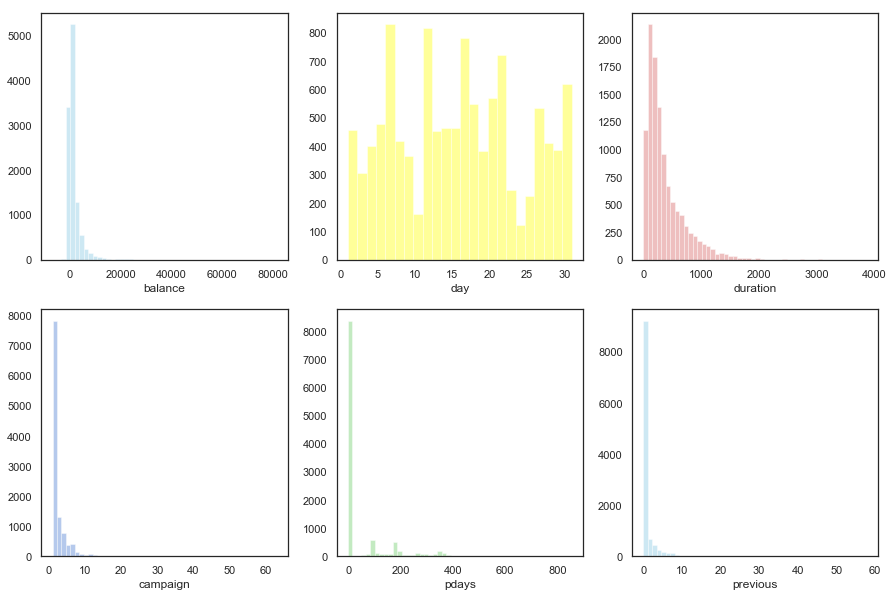

In [9]:
# numerical columns: colummns with numeric values
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

sns.set(style = 'white', palette = 'muted', color_codes = True)
colors = ['c', 'yellow', 'r', 'b', 'g', 'c']

i = 0   
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(15,10))

for num in num_columns:
    sns.distplot(bank[num], kde=False, color = colors[i], ax = axes[i//3, i%3])
    i += 1
;

The graphs of campaign, pdays, and previous have tails, which means there are outliers in these columns. In order to determine whether these outliers are noises, we proceed to use box plot to have a clearer understanding of these numerical attributes. 

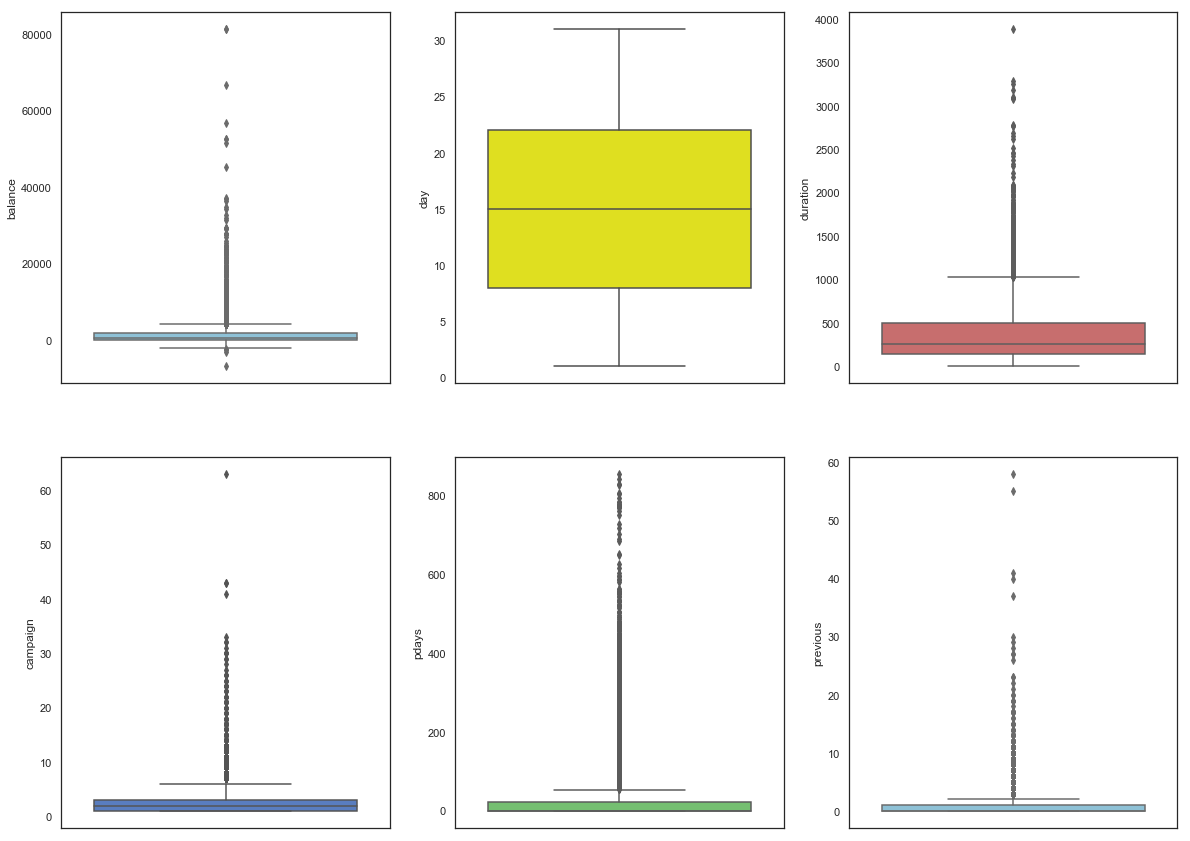

In [10]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

colors = ['c', 'yellow', 'r', 'b', 'g', 'c']
i = 0   
fig, axes = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20,15))
for num in num_columns:
    sns.boxplot(data = bank, y = num, hue = num, color = colors[i], ax = axes[i//3, i%3], )
    i += 1

Since the three columns campaign, pdays, and previous seem to have significant outliers, it is important that we take a better look at these columns. First, let's review the meaning of these columns.  
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
- previous: number of contacts performed before this campaign and for this client (numeric)

In [11]:
bank[['campaign', 'pdays', 'previous']].describe()

,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000
mean,2.508421,51.330407,0.832557
std,2.722077,108.758282,2.292007
min,1.000000,-1.000000,0.000000
25%,1.000000,-1.000000,0.000000
50%,2.000000,-1.000000,0.000000
75%,3.000000,20.750000,1.000000
max,63.000000,854.000000,58.000000


<span style="color:blue"> Most of the values of campaign attribute fall in the interval [1, 3], which mean most customers receive 1-3 calls. </span>
   
   Take a look of the percentage of campaign that are greater than 4 

In [12]:
len (bank[bank['campaign'] > 4] ) / len(bank) * 100

11.14495610105716

In [13]:
len (bank[bank['pdays'] == -1] ) / len(bank) * 100

74.5744490234725

In [14]:
len (df[df['previous'] > 20] ) / len(df) * 100

0.13438451890342232

Roughly 75% of columns pdays have values = -1. Since pdays is the number of days passed since last time the customers were contacted, we can exclude this column from the study since we are not sure what -1 stand for.

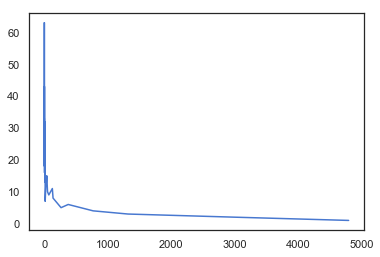

In [15]:
# campaign 
num_clients = bank['campaign'].value_counts()
num_calls = bank['campaign'].unique()

plt.plot(num_clients, num_calls);

In [16]:
opened = bank[bank['deposit'] == 'yes']
notOpened = bank[bank['deposit'] == 'no']
percentNotOpen = round((len(notOpened) / len(bank))*100, 2)
percentOpen = round((len(opened) / len(bank))*100, 2)
print('{} % of the clients opened a term deposit and {}% of the clients did not open a term deposit.'.format(percentOpen,percentNotOpen))

47.38 % of the clients opened a term deposit and 52.62% of the clients did not open a term deposit.


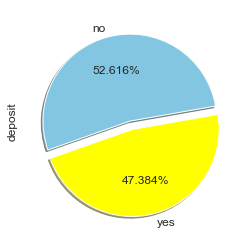

In [17]:
bank["deposit"].value_counts().plot.pie(explode=[0,0.1], autopct='%0.3f%%', shadow=True, colors=colors, 
                                             fontsize=12, startangle=10)
plt.show()

In [18]:
bank['education'].replace({'secondary': 'high school', 'tertiary': 'college', 'primary' : 'elementary'}, inplace = True)
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,high school,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,high school,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,high school,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,high school,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,college,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


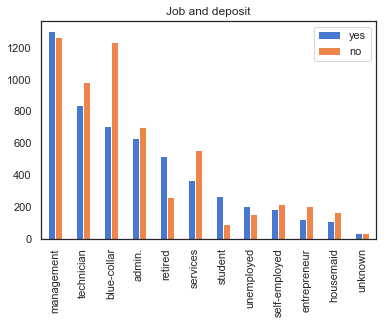

In [19]:
#job and deposit
job = pd.DataFrame()

job['yes'] = bank[bank['deposit'] == 'yes']['job'].value_counts()
job['no'] = bank[bank['deposit'] == 'no']['job'].value_counts()

job.plot.bar(title = 'Job and deposit')

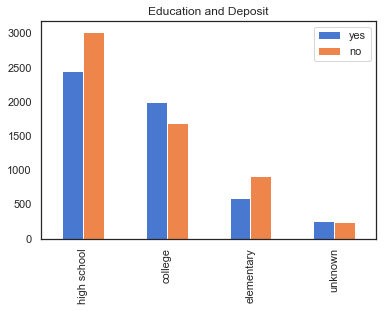

In [20]:
#education and deposit
edu = pd.DataFrame()

edu['yes'] = bank[bank['deposit'] == 'yes']['education'].value_counts()
edu['no'] = bank[bank['deposit'] == 'no']['education'].value_counts()

edu.plot.bar(title = 'Education and Deposit');

In [21]:
age = bank[['age']].describe()
age

,age
count,11162.000000
mean,41.231948
std,11.913369
min,18.000000
25%,32.000000
50%,39.000000
75%,49.000000
max,95.000000


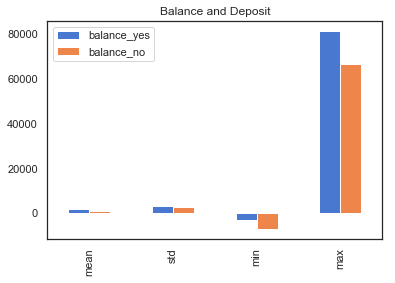

In [22]:
#balance and deposit

balance = pd.DataFrame()
balance['balance_yes'] = (bank[bank['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
balance['balance_no'] = (bank[bank['deposit'] == 'no'][['deposit','balance']].describe())['balance']

balance.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and Deposit');

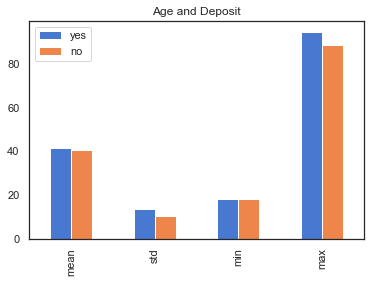

In [23]:
#age and deposit
age = pd.DataFrame()

age['yes'] = (bank[bank['deposit'] == 'yes'][['deposit', 'age']]).describe()['age']
age['no'] = (bank[bank['deposit'] == 'no'][['deposit', 'age']]).describe()['age']

age.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and Deposit');

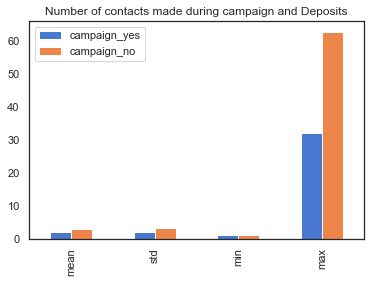

In [24]:
#number of contacts performed during this campaign ('campaign') and deposit
cam = pd.DataFrame()

cam['campaign_yes'] = (bank[bank['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
cam['campaign_no'] = (bank[bank['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

cam.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts made during campaign and Deposits');

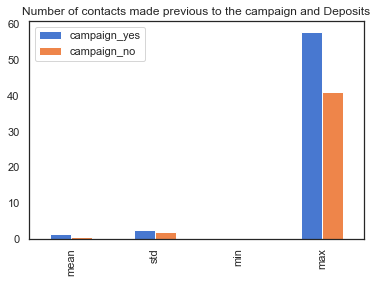

In [25]:
#number of contacts performed before this campaign ('campaign') and deposit
prev = pd.DataFrame()

prev['campaign_yes'] = (bank[bank['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
prev['campaign_no'] = (bank[bank['deposit'] == 'no'][['deposit','previous']].describe())['previous']

prev.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts made previous to the campaign and Deposits');

In [26]:
def replace_mean(df, column,row, limit):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column] <= limit:
        return row[column]
    else:
        mean = df[df[column] <= limit][column].mean()
        return mean

In [27]:
def encoding(table, column):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if table[column] == 'yes' else 0



In [28]:

def clean_data(df):
    
    table = df.copy()
    
    table = table.drop(columns = ['pdays'])
    
    #replace columns containing 'yes' and 'no' values to boolean variables
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        table[bool_col] = df.apply(lambda row: encoding(row, bool_col),axis=1)
    
    #convert categorical columns to one-hot encoding
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        table = pd.concat([table.drop(col, axis=1),
                                pd.get_dummies(table[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #impute incorrect values and drop original columns
    correct_cols = ['campaign', 'previous']
    for col in correct_cols:
        table[col] = df.apply(lambda row: replace_mean(table,col,row, 34),axis=1)
    
    return table

In [29]:
cleaned = clean_data(bank)

In [30]:
cleaned.head() 

,age,default,balance,housing,loan,day,duration,campaign,previous,deposit,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_elementary,education_high school,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1042,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,56,0,45,0,0,5,1467,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,41,0,1270,1,0,5,1389,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,55,0,2476,1,0,5,579,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,54,0,184,0,0,5,673,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [31]:
## Machine Learning 
X = cleaned.drop(columns='deposit')
y = cleaned[['deposit']]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
print(len(X_train), len(X_test),len(y_train), len(y_test))

7478 3684 7478 3684


In [34]:
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.09, gamma=0.11, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)
acc_train = accuracy_score(y_train, y_train_preds)
acc_test = accuracy_score(y_test, y_test_preds)

print(acc_train, acc_test)

/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/thaonguyen/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9181599358117144 0.8523344191096635


In [39]:
#train XGBoost model
def get_accuracy(n, learningRate, discountFactor): 
    accuracy = pd.DataFrame(columns=['Learning Rate', 'Discount Factor', 'Train Accuracy', 'Test Accuracy'])
    #learningRate = np.arange(0.01, 0.11, 0.01)
    #discountFactor = np.arange(0.01, 0.11, 0.01)
    for i in range(len(discountFactor)):
        xgb = xgboost.XGBClassifier(n_estimators=n, learning_rate=learningRate[i], gamma=discountFactor[i], subsample=0.75,
                           colsample_bytree=1, max_depth=7)
        xgb.fit(X_train,y_train.squeeze().values)

        #calculate and print scores for the model for top 15 features
        y_train_preds = xgb.predict(X_train)
        y_test_preds = xgb.predict(X_test)
        acc_train = accuracy_score(y_train, y_train_preds)
        acc_test = accuracy_score(y_test, y_test_preds)
        accuracy = accuracy.append({'Learning Rate':learningRate[i],'Discount Factor': discountFactor[i],
                               'Train Accuracy': acc_train, 'Test Accuracy': acc_test}, ignore_index = True)
    return accuracy


In [40]:
learning = np.arange(0.01, 0.2, 0.01)
discount = np.arange(0.01, 0.2, 0.01)
n = 100
first_trial = get_accuracy(n, learning, discount)


In [41]:
first_trial

,Learning Rate,Discount Factor,Train Accuracy,Test Accuracy
0,0.01,0.01,0.861594,0.836862
1,0.02,0.02,0.873094,0.842291
2,0.03,0.03,0.880182,0.842834
3,0.04,0.04,0.888473,0.849077
4,0.05,0.05,0.895828,0.850706
5,0.06,0.06,0.899572,0.853692
6,0.07,0.07,0.905991,0.850706
7,0.08,0.08,0.911206,0.852606
8,0.09,0.09,0.920701,0.852606
9,0.10,0.10,0.922840,0.857220


In [42]:
print(len(X_train), len(X_test),len(y_train), len(y_test))

7478 3684 7478 3684


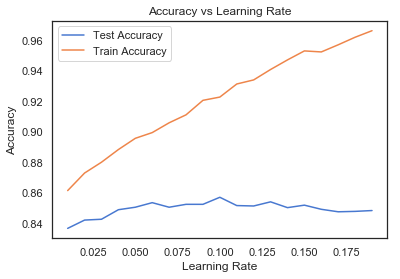

In [43]:
## Plot accuracy vs Learning rate
# since we have similar Learning Rate and Discount factor for each pair, Discount Factor graph should look the same
plt.plot('Learning Rate', 'Test Accuracy', data = first_trial)
plt.plot('Learning Rate', 'Train Accuracy', data = first_trial)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.legend();

In [44]:
## Change Discount Factor - Keep Learning Rate the same

learning = np.arange(0.01, 0.2, 0.01)
discount = np.flip(np.arange(0.01, 0.2, 0.01))
n = 100
second_trial = get_accuracy(n, learning, discount)
second_trial

,Learning Rate,Discount Factor,Train Accuracy,Test Accuracy
0,0.01,0.19,0.861728,0.837948
1,0.02,0.18,0.872025,0.841748
2,0.03,0.17,0.880182,0.843920
3,0.04,0.16,0.887403,0.847448
4,0.05,0.15,0.895427,0.849620
5,0.06,0.14,0.898235,0.853420
6,0.07,0.13,0.906258,0.853420
7,0.08,0.12,0.913212,0.856678
8,0.09,0.11,0.918160,0.852334
9,0.10,0.10,0.922840,0.857220


In [45]:
first_trial[first_trial['Test Accuracy'] == max(first_trial['Test Accuracy'])]

,Learning Rate,Discount Factor,Train Accuracy,Test Accuracy
9,0.1,0.1,0.92284,0.85722


In [46]:
second_trial[second_trial['Test Accuracy'] == max(second_trial['Test Accuracy'])]

,Learning Rate,Discount Factor,Train Accuracy,Test Accuracy
9,0.1,0.1,0.92284,0.85722


In [47]:
print(len(X_train), len(X_test),len(y_train), len(y_test))

7478 3684 7478 3684


In [48]:
 final = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.09, gamma=0.11, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
final.fit(X_train,y_train.squeeze().values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.11,
       learning_rate=0.09, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.75, verbosity=1)

In [49]:
xgb.feature_importances_?

Type:        property
String form: <property object at 0x1a18e2a0e8>
Docstring:  
Feature importances property

.. note:: Feature importance is defined only for tree boosters

    Feature importance is only defined when the decision tree model is chosen as base
    learner (`booster=gbtree`). It is not defined for other base learner types, such
    as linear learners (`booster=gblinear`).

Returns
-------
feature_importances_ : array of shape ``[n_features]``


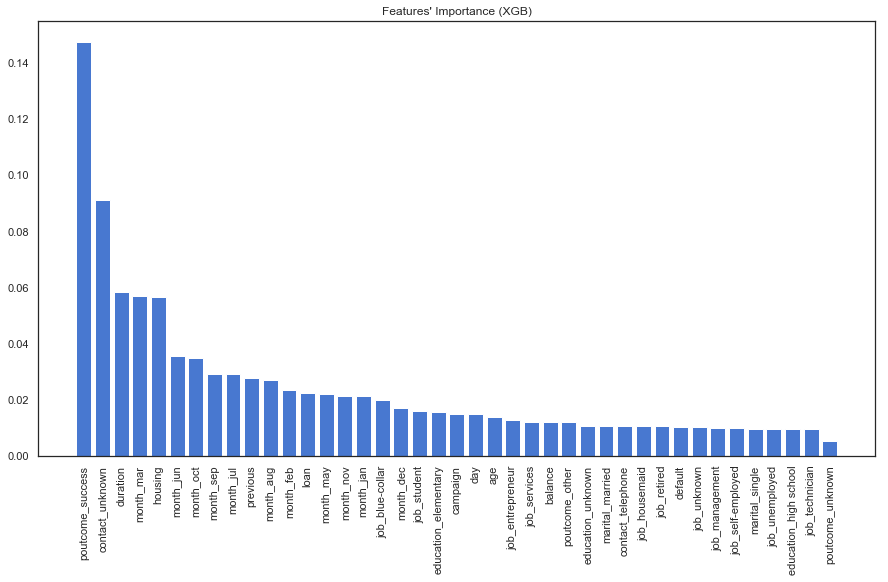

In [50]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, final.feature_importances_), key=lambda x: x[1] * -1)
featureImportance = pd.DataFrame(values, columns = headers)

#plot feature importances
plt.figure(figsize=(15, 8))
x_pos = np.arange(0, len(featureImportance))
plt.bar(x_pos, featureImportance['score'])
plt.xticks(x_pos, featureImportance['name'])
plt.xticks(rotation=90)
plt.title("Features' Importance (XGB)")

plt.show()

In [51]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
weight = xgb.get_booster().get_score(importance_type= 'weight')

In [52]:
cleaned.head()

,age,default,balance,housing,loan,day,duration,campaign,previous,deposit,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_elementary,education_high school,education_unknown,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1042,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,56,0,45,0,0,5,1467,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,41,0,1270,1,0,5,1389,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,55,0,2476,1,0,5,579,1.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,54,0,184,0,0,5,673,2.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [53]:
balance = cleaned[['balance', 'deposit']]
balance = balance[balance['deposit'] == 1]
balance.describe()

,balance,deposit
count,5289.000000,5289.0
mean,1804.267915,1.0
std,3501.104777,0.0
min,-3058.000000,1.0
25%,210.000000,1.0
50%,733.000000,1.0
75%,2159.000000,1.0
max,81204.000000,1.0
